# FX Computer Assignment
Simon Sun (zs892)

### Basic Setups

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy.stats import norm
import scipy.optimize as opt
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

In [2]:
r_f = 2.2/100
r_d = 6.5/100
convention = 365
S = 3.724
today = datetime(2019,1,15)
Expiray = np.array([datetime(2019,1,16), datetime(2019,1,22), datetime(2019,1,29), datetime(2019,2,15), datetime(2019,3,14),
                    datetime(2019,4,15), datetime(2019,6,15), datetime(2020,1,15)])
T = np.array([i.days for i in Expiray-today])/convention
Tenors = ['ON', '1W', '2W', '1M', '2M', '3M', '6M', '1Y']
ATM_vol = np.array([20.98, 13.91, 13.75, 14.24, 13.84, 13.82, 13.82, 13.94])
RR_vol = np.array([1.2, 1.3, 1.4, 1.5, 1.75, 2.0, 2.4, 2.9])
BF_vol = np.array([0.15, 0.20, 0.20, 0.22, 0.27, 0.32, 0.43, 0.55])
col = ['Tenor','Expiray','ATM','25d RR','25d BF']
df = pd.DataFrame([Tenors,Expiray,ATM_vol,RR_vol,BF_vol],index=col).T
df = df.set_index('Tenor')
ATM_vol = ATM_vol/100
RR_vol = RR_vol/100
BF_vol = BF_vol/100
df

,Expiray,ATM,25d RR,25d BF
Tenor,,,,
ON,2019-01-16,20.98,1.2,0.15
1W,2019-01-22,13.91,1.3,0.2
2W,2019-01-29,13.75,1.4,0.2
1M,2019-02-15,14.24,1.5,0.22
2M,2019-03-14,13.84,1.75,0.27
3M,2019-04-15,13.82,2,0.32
6M,2019-06-15,13.82,2.4,0.43
1Y,2020-01-15,13.94,2.9,0.55


### Problem 1

Specific Equations and Calibration Conditions Used In this Computer Assignment:

1.Premium Included Spote Delta:

$$\Delta_C = p^f\frac{K}{F}\mathcal{N}(d_2)$$
$$\Delta_P = -p^f\frac{K}{F}\mathcal{N}(-d_2)$$

2.Black-Scholes Pricing Formula for Vanilla FX:
$$C = F\mathcal{N}(d_1) - K\mathcal{N}(d_2)$$
$$P = -F\mathcal{N}(-d_1) + K\mathcal{N}(-d_2)$$

Where $$F=S e^{(r_d-r_f)t}$$ $$d_2=\frac{log(S/K)-\frac{1}{2}\sigma^2t}{\sigma\sqrt{t}}$$  $$d_1=\frac{log(S/K)+\frac{1}{2}\sigma^2t}{\sigma\sqrt{t}}$$  
and finally $p^f$ is the discounting factor of foreign currency

3.SABR IV Curve:
$$\sigma_{IV}(K,t) \approx \frac{\alpha}{(FK)^{\frac{1-\beta}{2}}
\left\{1+\frac{(1-\beta)^2}{24}\log^2{\frac{F}{K}}+\frac{(1-\beta)^4}{1920}\log^4{\frac{F}{K}}\right\}\\
\cdot(\frac{z}{x(z)})\cdot\left\{1+[\frac{(1-\beta)^2}{24}\frac{\alpha^2}{(FK)^{1-\beta}}
+\frac{1}{4}\frac{\rho\beta\nu\alpha}{(FK)^{\frac{1-\beta}{2}}}+\frac{2-3\rho^2}{24}\nu^2]t\right\}}$$

where
$$z=\frac{\nu}{\alpha}(FK)^{\frac{1-\beta}{2}}\log{\frac{F}{K}}$$
$$x(z)=\log{(\frac{\sqrt{1-2\rho z+z^2}+z-\rho}{1-\rho})}$$

4.The purpose of Calibration is to fit the above SABR IV Curve into the following market conventions:
Also to point out. In the 7 conditions below, the first 2 are not put in the calibration function. Because these two equals each has only one variable ($K_{BFPut}$ and $K_{BFCall}$). Their values can easily be solved before sovling the calibration process of the rest 5 conditions.

   i.) $K_{BFPut}=K_P(\sigma_{atm}+\sigma_{BF},\delta)$
    
   In specific, in this exercise, we are looking for the BS Strike K that statisfies market data for BF Put given volatility and delta
           
   ii.) $K_{BFCall}=K_C(\sigma_{atm}+\sigma_{BF},\delta)$
 
   In specific, in this exercise, we are looking for the BS Strike K that statisfies market data for BF Call given volatility and delta
    
   iii.) $\sigma(K_{ATM})=\sigma_{ATM}$
    
   the implied SABR volatility at $K_ATM$ should be equal to market observed volatility.
    
   iv.) $P^{model}(K_{BFPut})+C^{model}(K_{BFCall}) = P^{BS}(ATM+BF,K_{BFPut})+C^{BS}(ATM+BF,K_{BFPut})$
    
   In other words, the BF Call and Put Option price calculated with SABR implied volatility and market provided volatility should be equal / as close as possible
    
   v.) $\delta(K_{RRPut}) = 0.25$
    
   Delta calculated from the $K_{RRPut}$ strike should equal to $0.25$. In this case, 
   it requires both the SABR IV and $K_{RRPut}$ we calculated satisfies the equation / minimizes the error.

   vi.) $\delta(K_{RRCall}) = 0.25$
    
   Same as v.) just change to call

   vii.) $\sigma(K_{RRCall})-\sigma(K_{RRPut}) =\sigma_{RR}$
    
   This is how the $\sigma_{RR}$ in the data is defined

In [3]:
def delta_target(K):
    d2 =(np.log(S/K)+(r_d-r_f-.5 *sig**2)*t)/(sig*np.sqrt(t))
    if option_type == 'P':
        d2 = -d2
    return K*np.exp(-r_f*t)/S*norm.cdf(d2)-.25

def BS(sig,K,t,option_type):
    d1 =(np.log(S/K)+(r_d-r_f+.5 *sig**2)*t)/(sig*np.sqrt(t))
    d2 =(np.log(S/K)+(r_d-r_f-.5 *sig**2)*t)/(sig*np.sqrt(t))
    if option_type == "C":
        return S*norm.cdf(d1)-np.exp(-(r_d-r_f)*t)*K*norm.cdf(d2)
    return -S*norm.cdf(-d1)+np.exp(-(r_d-r_f)*t)*K*norm.cdf(-d2)

def delta(sig,K,t,option_type):
    d2 =(np.log(S/K)+(r_d-r_f-.5 *sig**2)*t)/(sig*np.sqrt(t))
    if option_type == 'P':
        return -(K*np.exp(-r_f*t)/S*norm.cdf(-d2))
    return K*np.exp(-r_f*t)/S*norm.cdf(d2)

def SABR_iv(K,t,alpha,beta,nu,rho):
    F = S*np.exp((r_d-r_f)*t)
    z = (nu/alpha)*(F*K)**((1-beta)/2)*np.log(F/K)
    x = np.log((np.sqrt(1-2*rho*z+z**2)+z-rho)/(1-rho))
    iv = (alpha/((F*K)**((1-beta)/2)*(1+(1-beta)**2/24*(np.log(F/K))**2+(1-beta)**4/1920*(np.log(F/K))**4))*
          (z/x)*(1+((1-beta)**2/24*alpha**2/(F*K)**(1-beta)+1/4*rho*beta*nu*alpha/(F*K)**((1-beta)/2)+(2-3*rho**2)/24*nu**2)*t))
    return iv

def SABR_market_conventions_targets(x):
    # x[0] = alpha, x[1] = nu, x[2] = rho, x[3] = RR_Call_Strike, x[4] = RR_Put_Strike ... as beta = 1
    cond0 = SABR_iv(atm_k,t,x[0],1,x[1],x[2]) - atm_vol
    cond1 = (BS(SABR_iv(bf_call_k,t,x[0],1,x[1],x[2]),bf_call_k,t,'C') + BS(SABR_iv(bf_put_k,t,x[0],1,x[1],x[2]),bf_put_k,t,'P')
             -BS(atm_vol+bf_vol,bf_call_k,t,'C')-BS(atm_vol+bf_vol,bf_put_k,t,'P'))
    cond2 = delta(SABR_iv(x[3],t,x[0],1,x[1],x[2]),x[3],t,'C') - 0.25
    cond3 = delta(SABR_iv(x[4],t,x[0],1,x[1],x[2]),x[4],t,'P') + 0.25
    cond4 = SABR_iv(x[3],t,x[0],1,x[1],x[2]) - SABR_iv(x[4],t,x[0],1,x[1],x[2]) - rr_vol
    return np.array([cond0,cond1,cond2,cond3,cond4])

In [4]:
ATM_K = [np.exp(-.5*ATM_vol[i]**2*T[i]+(r_d-r_f)*T[i])*S for i in range(len(ATM_vol))]
res = []
for i in range(len(ATM_vol)):
    t = T[i]
    K = S
    sig = ATM_vol[i]+BF_vol[i]
    option_type = 'C'
    bf_call_k = fsolve(delta_target,S)[0]
    option_type = "P"
    bf_put_k = fsolve(delta_target,S)[0]
    atm_k = ATM_K[i]
    atm_vol = ATM_vol[i]
    bf_vol = BF_vol[i]
    rr_vol = RR_vol[i]
    [alpha,nu,rho,rr_call_k,rr_put_k] = opt.least_squares(SABR_market_conventions_targets, x0=np.array([.2,5,0.5,4.5,3.5]),bounds=([0,0,-1,0,0],[np.inf,np.inf,1,np.inf,np.inf])).x
    bf_call_vol =  SABR_iv(bf_call_k,t,alpha,1,nu,rho)*100
    bf_put_vol =  SABR_iv(bf_put_k,t,alpha,1,nu,rho)*100
    rr_call_vol =  SABR_iv(rr_call_k,t,alpha,1,nu,rho)*100
    rr_put_vol =  SABR_iv(rr_put_k,t,alpha,1,nu,rho)*100
    atm_vol_iv = SABR_iv(atm_k,t,alpha,1,nu,rho)*100
    res += [[atm_k,bf_call_k,bf_put_k,rr_call_k,rr_put_k,atm_vol*100,atm_vol_iv,bf_call_vol,bf_put_vol,rr_call_vol,rr_put_vol,alpha,1,nu,rho]]
res_disp = pd.DataFrame(res,index = Tenors, columns = ['$K_{atm}$','$K_{BF\_Call}$','$K_{BF\_Put}$','$K_{RR\_Call}$','$K_{RR\_Put}$','$\sigma_{atm}$','$\sigma_{SABR\_atm}$','$\sigma_{SABR\_BF\_Call}$','$\sigma_{SABR\_BF\_Put}$','$\sigma_{SABR\_RR\_Call}$','$\sigma_{SABR\_RR\_Put}$','\u03B1','\u03B2','\u03BD','\u03C1'])
res_disp = res_disp[['\u03B1','\u03C1','\u03BD','$K_{atm}$','$\sigma_{atm}$','$K_{RR\_Call}$','$\sigma_{SABR\_RR\_Call}$','$K_{RR\_Put}$','$\sigma_{SABR\_RR\_Put}$','$K_{BF\_Call}$','$\sigma_{SABR\_BF\_Call}$','$K_{BF\_Put}$','$\sigma_{SABR\_BF\_Put}$']]
res_disp

,α,ρ,ν,$K_{atm}$,$\sigma_{atm}$,$K_{RR\_Call}$,$\sigma_{SABR\_RR\_Call}$,$K_{RR\_Put}$,$\sigma_{SABR\_RR\_Put}$,$K_{BF\_Call}$,$\sigma_{SABR\_BF\_Call}$,$K_{BF\_Put}$,$\sigma_{SABR\_BF\_Put}$
ON,0.208316,0.270427,5.921948,3.724214,20.98,3.753152,21.740659,3.697539,20.540659,3.752342,21.716031,3.696771,20.532273
1W,0.137238,0.310117,3.152149,3.726381,13.91,3.778947,14.777745,3.680465,13.477745,3.776585,14.732539,3.678295,13.466666
2W,0.135728,0.338366,2.223834,3.728795,13.75,3.803296,14.669511,3.665352,13.269511,3.799671,14.618548,3.662065,13.254403
1M,0.140579,0.348133,1.498830,3.734408,14.24,3.851654,15.228308,3.638105,13.728308,3.845809,15.172656,3.632887,13.710908
2M,0.136335,0.375894,1.208628,3.743831,13.84,3.904940,15.008416,3.618075,13.258416,3.895439,14.931532,3.609817,13.234751
3M,0.135936,0.399550,1.036974,3.754843,13.82,3.961679,15.168078,3.600910,13.168078,3.947904,15.069126,3.589227,13.137359
6M,0.135431,0.418621,0.902906,3.775892,13.82,4.058127,15.485377,3.580556,13.085377,4.036065,15.343433,3.562522,13.046570
1Y,0.136726,0.472635,0.601138,3.850035,13.94,4.344399,15.972825,3.554611,13.072825,4.299651,15.780403,3.520647,13.008245


### Problem 2

In [5]:
def delta_target(K):
    sig = SABR_iv(K,t,alpha,beta,nu,rho)
    d2 =(np.log(S/K)+(r_d-r_f-.5 *sig**2)*t)/(sig*np.sqrt(t))
    if option_type == 'P':
        d2 = -d2
    return K*np.exp(-r_f*t)/S*norm.cdf(d2)-.1

At Tenor: ON, the -10% Put to +10% Call Strike range is (3.673917885571823,3.780917885571811)
At Tenor: 1W, the -10% Put to +10% Call Strike range is (3.6396287011578328,3.8336287011578114)
At Tenor: 2W, the -10% Put to +10% Call Strike range is (3.6094925273124523,3.8824925273124222)
At Tenor: 1M, the -10% Put to +10% Call Strike range is (3.5537495877948366,3.97774958779479)
At Tenor: 2M, the -10% Put to +10% Call Strike range is (3.5084566237044377,4.084456623704375)
At Tenor: 3M, the -10% Put to +10% Call Strike range is (3.4674657249116225,4.199465724911542)
At Tenor: 6M, the -10% Put to +10% Call Strike range is (3.4110505228312338,4.4030505228311245)
At Tenor: 1Y, the -10% Put to +10% Call Strike range is (3.3061041941589444,4.9891041941587595)


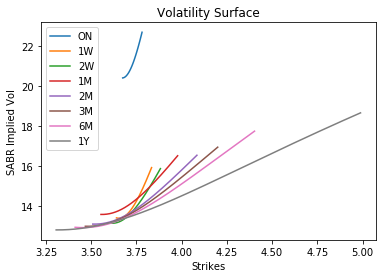

In [22]:
for i in range(len(res)):
    alpha,beta,nu,rho = res[i][-4:]
    t = T[i]
    option_type = 'C'
    K_call = fsolve(delta_target,S)[0]
    option_type = 'P'
    K_put = fsolve(delta_target,S)[0]
    strikes = np.arange(K_put,K_call,.001)
    vols = [SABR_iv(i,t,alpha,beta,nu,rho)*100 for i in strikes]
    print("At Tenor: "+ str(Tenors[i])+', the -10% Put to +10% Call Strike range is ('+str(strikes[0])+","+str(strikes[-1])+")")
    plt.plot(strikes,vols)
plt.title('Volatility Surface')
plt.xlabel('Strikes')
plt.ylabel('SABR Implied Vol')
plt.legend(Tenors)
plt.show()